## This notebook contains all the code used for training the model which is used for forecasting CO2 emissions.
Since the model itself is not included in this repo (but only the data it was trained on), you can use this code to create the model before using this package.

#### Imports

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline

#### Load dataset

In [5]:
df = pd.read_pickle('co2_dataset.zip', compression='zip')
print(f'df contains NaNs: {df.isna().any().any()}')

df contains NaNs: False


In [6]:
df.head()

epoch    windon  windoff  solar      load  prices         co2
0  1.546297e+09  18879.75  5069.00    0.0  43213.25   28.32  298.240217
1  1.546301e+09  20626.50  5042.25    0.0  41275.75   10.07  266.522473
2  1.546304e+09  22355.50  5028.50    0.0  40187.50   -4.08  262.594215
3  1.546308e+09  24032.50  4977.75    0.0  39909.00   -9.91  260.190772
4  1.546312e+09  25452.00  4907.25    0.0  40258.00   -7.41  250.496683

#### Inspect dataset

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

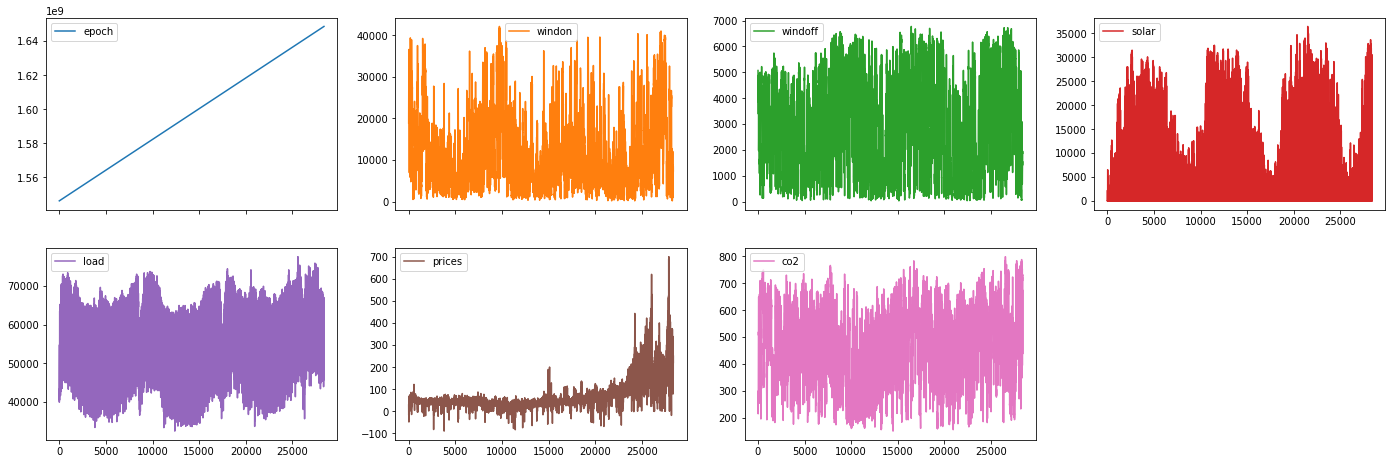

In [7]:
df.plot(subplots=True, layout=(3, 4), figsize=(24, 12))

#### Data preprocessing
#### add temporal features (for german local time always)

In [8]:
df['datetime_de'] = pd.to_datetime(df.epoch, unit='s').dt.tz_localize('utc').dt.tz_convert('Europe/Berlin')

In [9]:
df['hour_of_day'] = df.datetime_de.dt.hour
df['day_of_week'] = df.datetime_de.dt.weekday

# cet/cest change not considered here, but ignored since the offset
# of one hour has no big impact in a range from 0 to ~8760 hours
df['hour_of_year'] = ((df.datetime_de.dt.dayofyear - 1) * 24) + df.datetime_de.dt.hour

In [10]:
df = df.drop(columns=['datetime_de', 'epoch'])
df.head()

windon  windoff  solar      load  prices         co2  hour_of_day  \
0  18879.75  5069.00    0.0  43213.25   28.32  298.240217            0   
1  20626.50  5042.25    0.0  41275.75   10.07  266.522473            1   
2  22355.50  5028.50    0.0  40187.50   -4.08  262.594215            2   
3  24032.50  4977.75    0.0  39909.00   -9.91  260.190772            3   
4  25452.00  4907.25    0.0  40258.00   -7.41  250.496683            4   

   day_of_week  hour_of_year  
0            1             0  
1            1             1  
2            1             2  
3            1             3  
4            1             4

#### Transform catigorial weekdays to one-hot encoded weekdays
drop one of the weekday columns [to avoid multicollinearity](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a)
here we drop mondays because...well no one likes mondays

In [11]:
# replace numerical values with categorical ones and apply one-hot-encoding
df['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
df = pd.get_dummies(df, columns=['day_of_week'])
df = df.drop(columns=['day_of_week_mon'])
df.head()

windon  windoff  solar      load  prices         co2  hour_of_day  \
0  18879.75  5069.00    0.0  43213.25   28.32  298.240217            0   
1  20626.50  5042.25    0.0  41275.75   10.07  266.522473            1   
2  22355.50  5028.50    0.0  40187.50   -4.08  262.594215            2   
3  24032.50  4977.75    0.0  39909.00   -9.91  260.190772            3   
4  25452.00  4907.25    0.0  40258.00   -7.41  250.496683            4   

   hour_of_year  day_of_week_fri  day_of_week_sat  day_of_week_sun  \
0             0                0                0                0   
1             1                0                0                0   
2             2                0                0                0   
3             3                0                0                0   
4             4                0                0                0   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  
0                0                1                0  
1                0                1                0  
2                0                1                0  
3                0                1                0  
4                0                1                0

#### Convert cyclical/temporal featues according to [this method](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

In [12]:
c_features = ['hour_of_day', 'hour_of_year']
c_numbers = [24, 8760]
for f, n in zip(c_features, c_numbers):
    df[f + '_sin'] = np.sin(df[f]*(2.*np.pi/n))
    df[f + '_cos'] = np.cos(df[f]*(2.*np.pi/n))
df.drop(columns=c_features, inplace=True)
df.head()

windon  windoff  solar      load  prices         co2  day_of_week_fri  \
0  18879.75  5069.00    0.0  43213.25   28.32  298.240217                0   
1  20626.50  5042.25    0.0  41275.75   10.07  266.522473                0   
2  22355.50  5028.50    0.0  40187.50   -4.08  262.594215                0   
3  24032.50  4977.75    0.0  39909.00   -9.91  260.190772                0   
4  25452.00  4907.25    0.0  40258.00   -7.41  250.496683                0   

   day_of_week_sat  day_of_week_sun  day_of_week_thu  day_of_week_tue  \
0                0                0                0                1   
1                0                0                0                1   
2                0                0                0                1   
3                0                0                0                1   
4                0                0                0                1   

   day_of_week_wed  hour_of_day_sin  hour_of_day_cos  hour_of_year_sin  \
0                0         0.000000         1.000000          0.000000   
1                0         0.258819         0.965926          0.000717   
2                0         0.500000         0.866025          0.001435   
3                0         0.707107         0.707107          0.002152   
4                0         0.866025         0.500000          0.002869   

   hour_of_year_cos  
0          1.000000  
1          1.000000  
2          0.999999  
3          0.999998  
4          0.999996

#### Split data into features and targets

In [13]:
use_features = [c for c in df.columns if c != 'co2']  # use all columns except co2 (that's y)

# store columns and indices before scaling
cols = {c: i for i, c in enumerate(df.columns)}
idx = {ix: i for i, ix in enumerate(df.index)}

df_y = df['co2']
df_X = df.loc[:, [k for k in cols if k != 'co2' and k in use_features]]
y = df_y.values
X = df_X.values

In [14]:
df_X.head()

windon  windoff  solar      load  prices  day_of_week_fri  \
0  18879.75  5069.00    0.0  43213.25   28.32                0   
1  20626.50  5042.25    0.0  41275.75   10.07                0   
2  22355.50  5028.50    0.0  40187.50   -4.08                0   
3  24032.50  4977.75    0.0  39909.00   -9.91                0   
4  25452.00  4907.25    0.0  40258.00   -7.41                0   

   day_of_week_sat  day_of_week_sun  day_of_week_thu  day_of_week_tue  \
0                0                0                0                1   
1                0                0                0                1   
2                0                0                0                1   
3                0                0                0                1   
4                0                0                0                1   

   day_of_week_wed  hour_of_day_sin  hour_of_day_cos  hour_of_year_sin  \
0                0         0.000000         1.000000          0.000000   
1                0         0.258819         0.965926          0.000717   
2                0         0.500000         0.866025          0.001435   
3                0         0.707107         0.707107          0.002152   
4                0         0.866025         0.500000          0.002869   

   hour_of_year_cos  
0          1.000000  
1          1.000000  
2          0.999999  
3          0.999998  
4          0.999996

#### Split data into training and testing data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print(f'features used: {use_features}')

X_train shape: (19873, 15)
y_train shape: (19873,)
X_test shape: (8518, 15)
y_test shape: (8518,)
features used: ['windon', 'windoff', 'solar', 'load', 'prices', 'day_of_week_fri', 'day_of_week_sat', 'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'hour_of_day_sin', 'hour_of_day_cos', 'hour_of_year_sin', 'hour_of_year_cos']


#### Fit model

In [16]:
# initialize model
mdl = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=6)

# train model
mdl.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=6, random_state=42)

#### Predict using the test data

In [17]:
def predict_rf_with_intervals(model, X, clip_upper=.75, clip_lower=.25):
    """
    This method predicts the target for each estimator of e.g. a random
    forest regressor and returns a lower bound, upper bound (based on
    the provided quantiles) as well as the actual prediction of the
    model.
    https://blog.datadive.net/prediction-intervals-for-random-forests/
    """
    err_down = []
    err_up = []
    avg_pred = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1, -1))[0])
        # take the clip_bottom-percentile as lower bound of the prediction interval
        err_down.append(np.quantile(preds, clip_lower, method='lower'))
        # take the clip_top-percentile as upper bound of the prediction interval
        err_up.append(np.quantile(preds, clip_upper, method='higher'))
        # actual prediction is the average across all trees of the random forest
        avg_pred.append(np.mean(np.array(preds)))
    return np.array(err_down), np.array(avg_pred), np.array(err_up)

In [18]:
err_down, y_pred, err_up = predict_rf_with_intervals(mdl, X_test)

#### Plot target vs. prediction for a subset of the predicted data

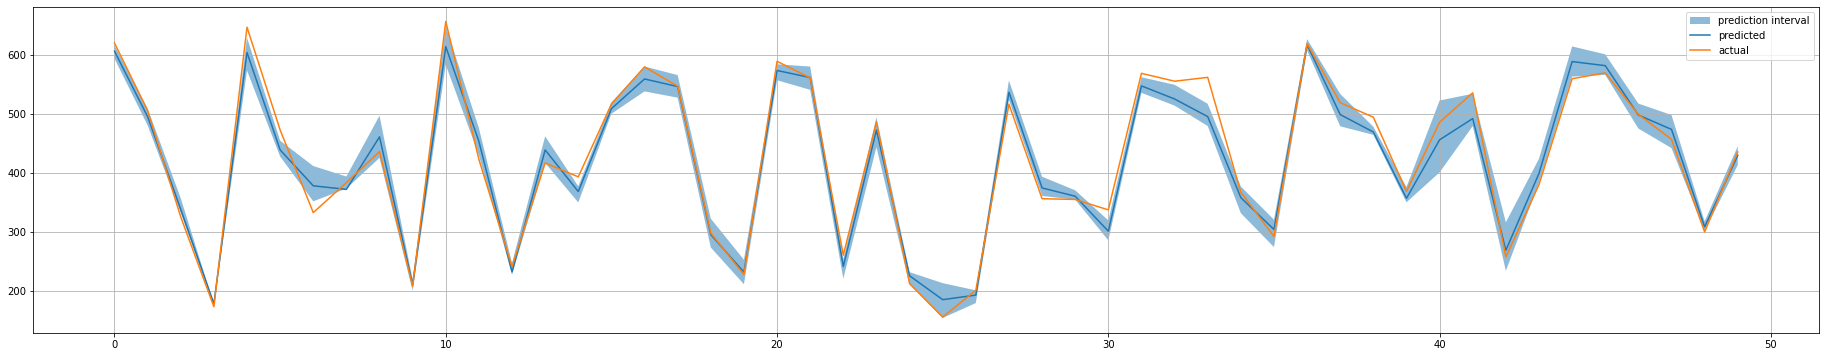

In [19]:
fig, ax = plt.subplots(figsize=(32, 6))
subset = (50, 100)
ax.fill_between(x=range(subset[1] - subset[0]), y1=err_down[subset[0]:subset[1]], y2=err_up[subset[0]:subset[1]], alpha=.5, label='prediction interval')
ax.plot(y_pred[subset[0]:subset[1]], label='predicted')
ax.plot(y_test[subset[0]:subset[1]], label='actual')
ax.grid()
ax.legend()

#### Plot the correlation between predicted and actual values

Text(0, 0.5, 'y_test')

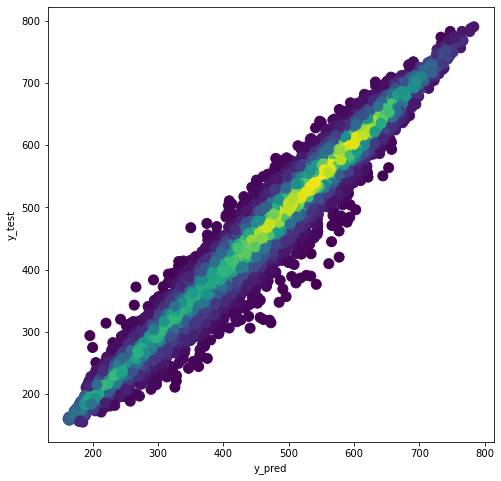

In [20]:
xy = np.vstack([y_pred, y_test])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_pred, y_test, c=z, s=100, cmap='viridis')
ax.set_xlabel('y_pred')
ax.set_ylabel('y_test')

#### Calculate some error metrics

In [21]:
errors = y_pred - y_test
mean_error = np.mean(errors)
absolute_errors = np.abs(errors)
mean_absolute_error = np.mean(absolute_errors)
_mean_absolute_percentage_error = 100 / len(y_test) * np.sum(absolute_errors / np.abs(y_test))
report = []
report.append(f'Mean Error: {round(mean_error, 2)} g_CO2/kWh')
report.append(f'Pearson Correlation Coefficient: {round(100 * np.corrcoef(y_pred, y_test)[0][1], 2)} %')
report.append(f'Mean Absolute Error: {round(mean_absolute_error, 2)} g_CO2/kWh')
report.append(f'Mean Absolute Percentage Error: {round(_mean_absolute_percentage_error, 2)} %')
report.append(f'Accuracy (target inside prediction interval): {round((np.sum([err_down[i] <= y_test[i] <= err_up[i] for i in range(len(y_test))]) / len(y_test)) * 100, 2)} %')
report.append(f'Average span of prediction interval: {np.round(np.mean(err_up - err_down), 2)} g_CO2/kWh')
report = '\n'.join(report)
print(report)

Mean Error: 0.82 g_CO2/kWh
Pearson Correlation Coefficient: 98.22 %
Mean Absolute Error: 19.31 g_CO2/kWh
Mean Absolute Percentage Error: 4.71 %
Accuracy (target inside prediction interval): 62.87 %
Average span of prediction interval: 40.99 g_CO2/kWh


#### Export model

In [22]:
from pickle import dump
dump(mdl, open('CO2EmissionTool/model_data/random_forest.pkl', 'wb'))